## The problem statement

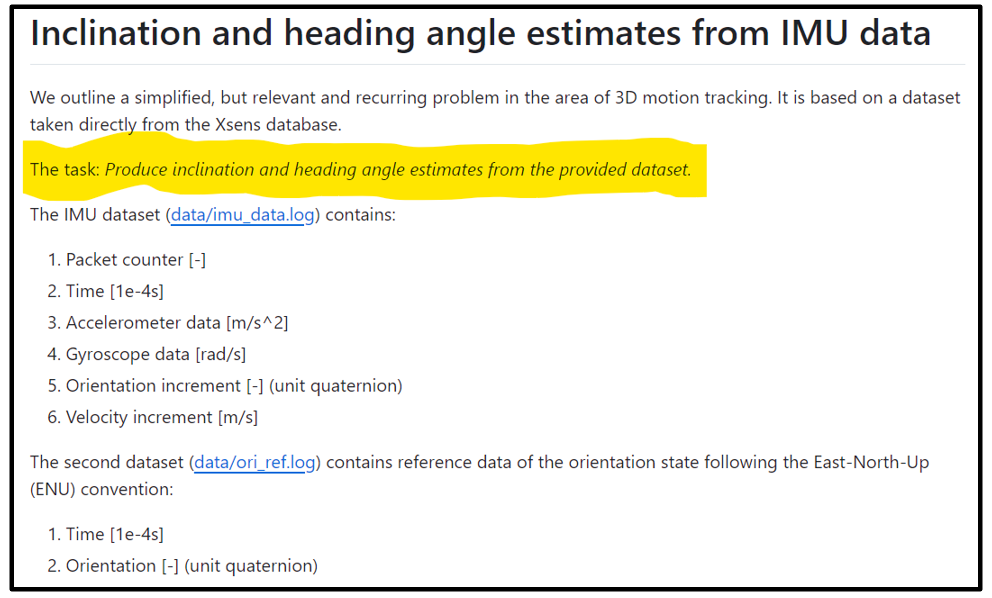

## What are quaternions?

1. Quaternions are four-dimensional mathematical structures
2. Their workings can be understood from an algebraic perspective
3. The three-dimensional geometric operations of vector dot and cross products can be viewed as a consequence of the algebraic properties of the four-dimensional quaternions
4. This consequence finds application in motivating the connection between three-dimensional rotations and quaternions
5. Quaternions are an effective way of dealing with three-dimensional rotations and their time derivatives
6. We will code up some of the basic properties of quaternions like conjugation, products and derivatives
7. The quaternion operations that we code up will be an important part of our workflow

## Some context

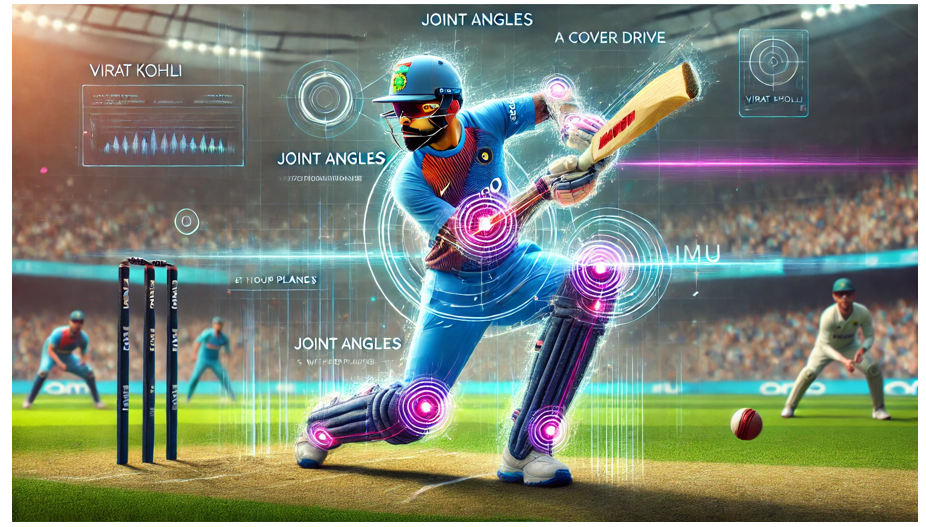

Credits: DALL-E 2024

## Why PINNs?

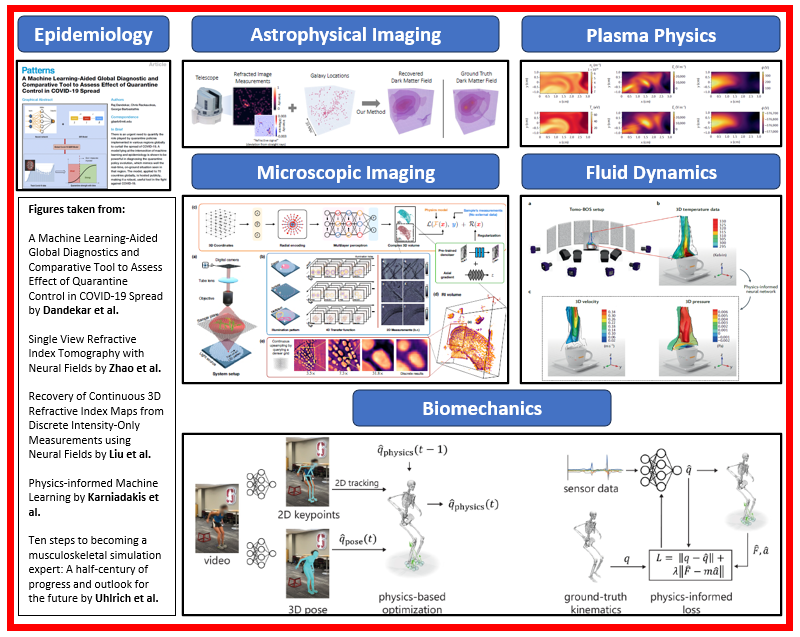

1. I was personally very motivated and curious to explore the use of PINNs for this assignment as I believe it is a fascinating approach which has a lot of potential
2. PINNs have been used in domains ranging from fluid mechanics to plasma physics and from epidemiology to computational imaging applications covering a spectrum from microscopy to astrophysics. I wanted to add wearable motion tracking to that list!
3. Scott Delp's lab at Stanford - one of the world's leading labs in biomechanical motion tracking state the followt papeel methods for combining physics and data into unified models will likely be a popular theme in future biomechanics research"
4. PINNs have several other advantages that we will not discuss right now in the spirit of keeping the discussion as elementary as possible

## How to use PINNs to solve the problem?

1. By the observed "universal approximation" capabilities of deep neural nets, they have the potential to express any function
2. Replace the quantity of interest with a neural network
3. Feed the neural net as input to the equations representing the underlying physical laws
4. Carry out the downstream optimization worflow that is typical of neural network setups

## But what are Neural Networks?

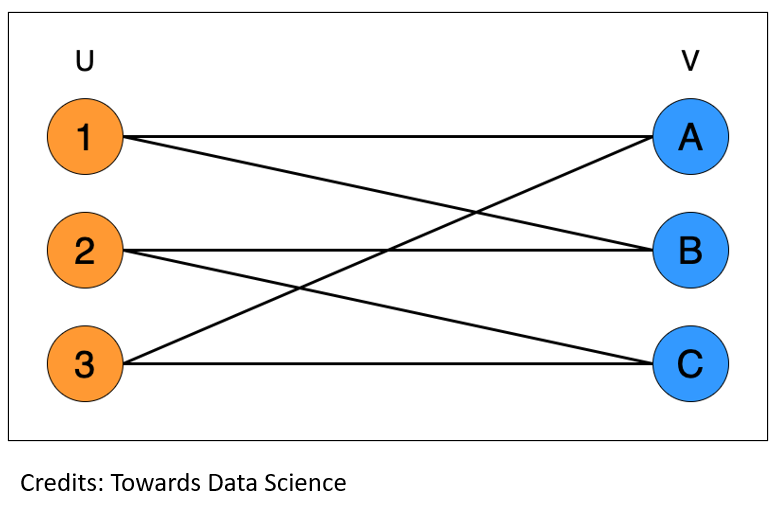

1. Neural Networks are mathematical abstractions of intelligence in the form of bipartite graphs
2. The nodes of the bipartite graph are called neurons and are fundamental information processing units
3. These Neural Networks can be thought of as universal function approximators owing to their "observed" approximation capabilities
4. The use of the word "observed" has a lot of subtle context and while it is worth mentioning, we will not get into it now!

## Import libraries

In [1]:
import time
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt

1. Unlike PyTorch which is a unified platform for coding up neural networks, JAX is modular
2. The modular nature of JAX provides flexibility and requires a separate library for setting up neural net architectures and a different one for optimization
3. Here we will use Equinox for setting up the neural net architecture and Optax for optimization
4. Equinox and Optax are designed specifically for use with JAX
5. While JAX has a steeper learning curve and is not as straightforward as PyTorch, it is incredibly fast owing to its features like just-in-time (jit) compilation and vectorized mapping (vmap)
6. We will use Pandas for reading in our data - it is a very popular library for data wrangling

## Load the reference file

In [2]:
file_path_ref = 'ori_reference.log'
with open(file_path_ref, 'r') as file:
    lines = file.readlines()

## What does the reference file look like?

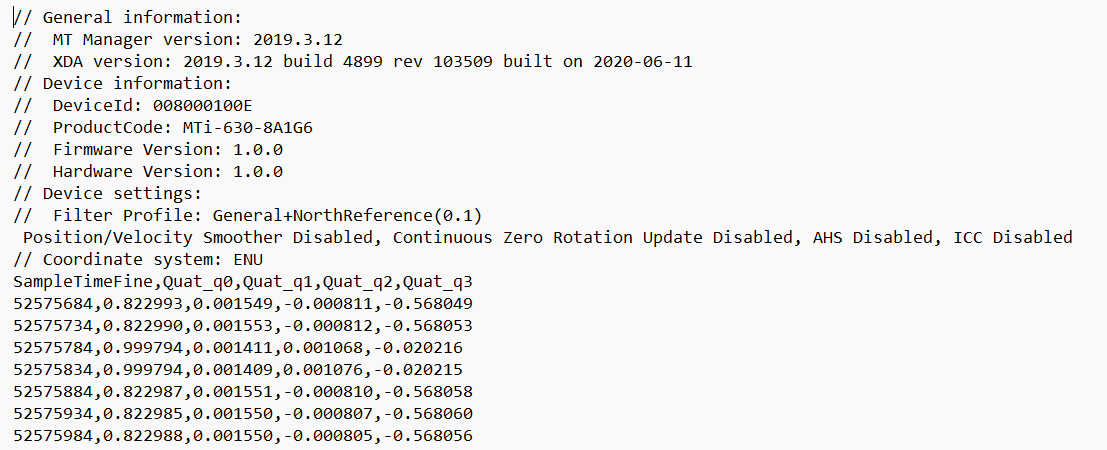

## Filter out lines from the reference file that start with "//"

In [3]:
filtered_lines = [line for line in lines if not line.strip().startswith('//')]

1. The one-line code above uses a list comprehension
2. List comprehensions provide compact one-line syntax for creating lists via for loops

## Write the filtered lines to a temporary CSV file

In [4]:
temp_file_path = 'filtered_data.csv'
with open(temp_file_path, 'w') as file:
    file.writelines(filtered_lines)

## Read the CSV file and specify that the second row contains the header

In [5]:
df_ref = pd.read_csv(temp_file_path, header=1)

## How did we read in the data?

In [6]:
type(df_ref)

pandas.core.frame.DataFrame

## What is a Pandas DataFrame?

A Pandas DataFrame is a data container that looks like an Excel Spreadsheet

## View contents of the data frame

In [7]:
df_ref.head()

,SampleTimeFine,Quat_q0,Quat_q1,Quat_q2,Quat_q3
0,52575684,0.822993,0.001549,-0.000811,-0.568049
1,52575734,0.822990,0.001553,-0.000812,-0.568053
2,52575784,0.999794,0.001411,0.001068,-0.020216
3,52575834,0.999794,0.001409,0.001076,-0.020215
4,52575884,0.822987,0.001551,-0.000810,-0.568058


## Load the data file

In [8]:
file_path = 'imu_data.log'
with open(file_path, 'r') as file:
    data = file.readlines()

## What does the data file look like?

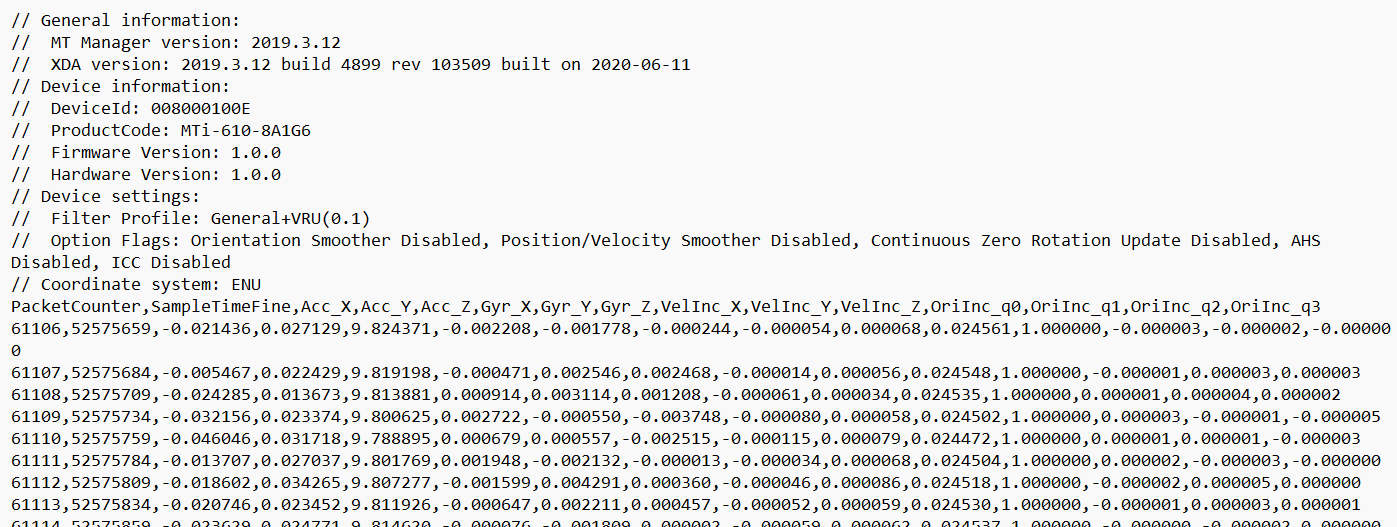

## Locate where the actual data starts

In [9]:
data_start_index = None
for index, line in enumerate(data):
    if not line.startswith('//'):
        data_start_index = index
        break

## Read the data into a DataFrame, skipping the initial metadata lines

In [10]:
df = pd.read_csv(file_path, skiprows=data_start_index)

## View contents of the DataFrame

In [11]:
df.head()

,PacketCounter,SampleTimeFine,Acc_X,Acc_Y,Acc_Z,Gyr_X,Gyr_Y,Gyr_Z,VelInc_X,VelInc_Y,VelInc_Z,OriInc_q0,OriInc_q1,OriInc_q2,OriInc_q3
0,61106,52575659,-0.021436,0.027129,9.824371,-0.002208,-0.001778,-0.000244,-0.000054,0.000068,0.024561,1.0,-0.000003,-0.000002,-0.000000
1,61107,52575684,-0.005467,0.022429,9.819198,-0.000471,0.002546,0.002468,-0.000014,0.000056,0.024548,1.0,-0.000001,0.000003,0.000003
2,61108,52575709,-0.024285,0.013673,9.813881,0.000914,0.003114,0.001208,-0.000061,0.000034,0.024535,1.0,0.000001,0.000004,0.000002
3,61109,52575734,-0.032156,0.023374,9.800625,0.002722,-0.000550,-0.003748,-0.000080,0.000058,0.024502,1.0,0.000003,-0.000001,-0.000005
4,61110,52575759,-0.046046,0.031718,9.788895,0.000679,0.000557,-0.002515,-0.000115,0.000079,0.024472,1.0,0.000001,0.000001,-0.000003


## Data categorization parameters

In [12]:
content_str = "low_freq_trend"
example_idx = 0

## Data categorization information

In [13]:
truncate_start_idx = None
if content_str == "low_freq_trend":
    truncate_start_idx_list = [8000, 10000, 11000, 12000]
elif content_str == "high_freq_trend":
    truncate_start_idx_list = [90837, 110726, 262387, 220502]
    
truncate_length = 1000

## Data slicing - start

In [14]:
truncate_start_idx = truncate_start_idx_list[example_idx]
truncate_start_ref_idx = None
while truncate_start_ref_idx is None:
    if df['SampleTimeFine'][truncate_start_idx] in df_ref['SampleTimeFine'].values:
        truncate_start_ref_idx = df_ref[df_ref['SampleTimeFine'] == df['SampleTimeFine'][truncate_start_idx]].index[0]
    else:
        truncate_start_idx += 1  

## Data slicing - end

In [15]:
truncate_end_idx = truncate_start_idx + truncate_length
truncate_end_ref_idx = None
while truncate_end_ref_idx is None:
    if df['SampleTimeFine'][truncate_end_idx] in df_ref['SampleTimeFine'].values:
        truncate_end_ref_idx = df_ref[df_ref['SampleTimeFine'] == df['SampleTimeFine'][truncate_end_idx]].index[0]
    else:
        truncate_end_idx += 1 

## Data categorization and slicing - notes

1. The data being used for demonstrating "proof-of-concept" is a small subset of the actual data that may be categorized based on visual inspection as eiter having a low-frequency or high-frequency signature
2. This small subset based on the categorization consists of small data slices that are feasible to run on a laptop given the constraints of assignment time and computational resources
3. The start and end indices for slicing are decided based on the Data categorization information and picked based on the Data categorization parameters
4. The start and end indices for the training data slices need to align with the corresponding indices in the reference data for validation purposes
5. However, the reference data has a lower resolution and does not match the training data one-to-one
6. Thus, an alignment procedure needs to be performed during the data slicing to esnure that both, training and reference data can be suitably extracted

## Extract and normalize training data timestamps

In [16]:
t_raw_array = jnp.array(df['SampleTimeFine'].values).reshape(-1, 1)
t_array_full = 10**-4 * (t_raw_array - t_raw_array[0])
t_array = t_array_full[truncate_start_idx:truncate_end_idx, :]

## Extract and normalize reference data timestamps

In [17]:
t_ref_raw_array = jnp.array(df_ref['SampleTimeFine'].values).reshape(-1, 1)
t_ref_array_full = 10**-4 * (t_ref_raw_array - t_ref_raw_array[0])
t_ref_array = t_ref_array_full[truncate_start_ref_idx:truncate_end_ref_idx, :]

## Notes on normalization

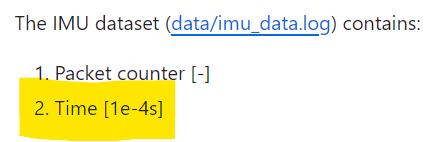

1. Normalization is a standardization procedure that makes our data easier to work with
2. We first extract the valued of the column from the data frame corresponding to the timestamps, convert it into a JAX numpy array (for compatibility with JAX) and then reshape it to a column vector so that the shape is well-defined
3. Next we convert the data to seconds by multiplying by 10**-4 based on the information provided on the assignment webpage
4. Finally we slice the data based on the start and end indices defined earlier

## Extract IMU sensor data

In [18]:
data_acc_full = jnp.array(df[['Acc_X', 'Acc_Y', 'Acc_Z']].values.tolist())
data_gyro_full = jnp.array(df[['Gyr_X', 'Gyr_Y', 'Gyr_Z']].values.tolist())

## Slice IMU sensor data

In [19]:
data_acc = data_acc_full[truncate_start_idx:truncate_end_idx, :]
data_gyro = data_gyro_full[truncate_start_idx:truncate_end_idx, :]

## Extract reference orientation data

In [20]:
data_quat_full = jnp.array(df_ref[list(df_ref.columns[1:])].values.tolist())

## Slice reference orientation data

In [21]:
data_quat = data_quat_full[truncate_start_ref_idx:truncate_end_ref_idx, :]

## Assign the boundary condition orientation

In [22]:
q_bc_left = data_quat[0]
q_bc_right = data_quat[-1]

## PINN diagram

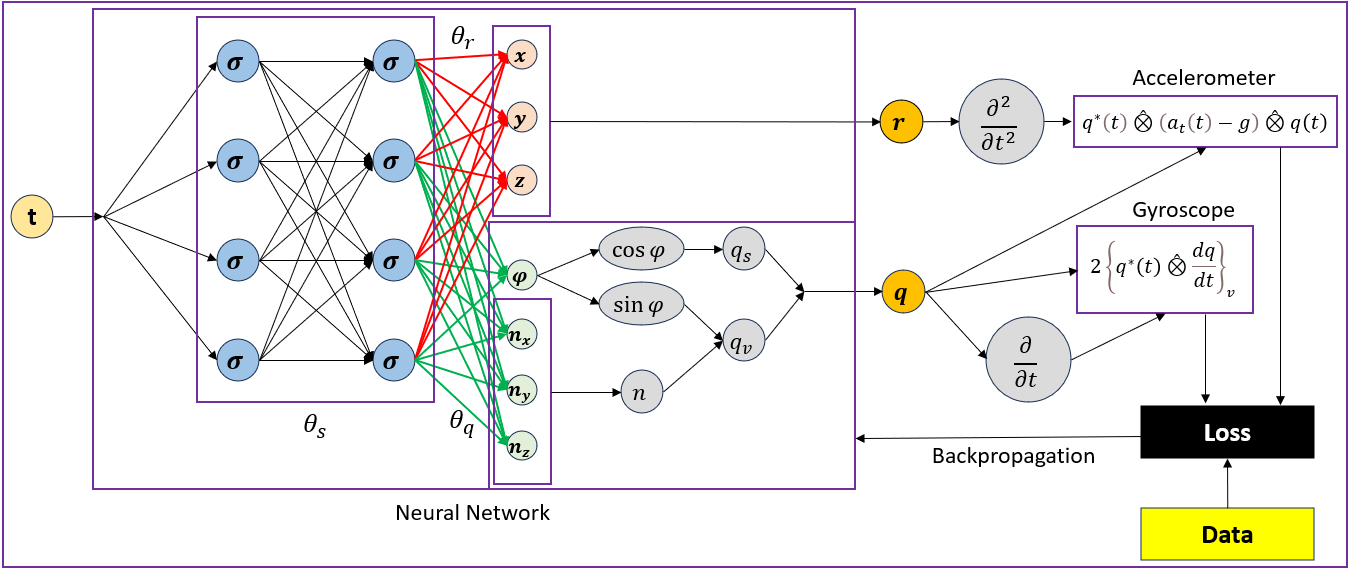

## Define Neural Network class

In [23]:
class PositionQuaternionNN(eqx.Module):
    layers: list
    final_layer_r: eqx.Module
    final_layer_theta: eqx.Module
    final_layer_v: eqx.Module

    def __init__(self, key, hidden_dim=128, hidden_num=4):
        # Create random keys for initializing weights
        key1, key2, key3, key4, key5 = jax.random.split(key, 5)
        
        self.layers = []
        self.layers.append(eqx.nn.Linear(1, hidden_dim, key=key1))
        for hidden_idx in range(hidden_num):
            key2, subkey = jax.random.split(key2)
            self.layers.append(eqx.nn.Linear(hidden_dim, hidden_dim, key=key2))
        
        # Define the final layers for r(t), theta, and v
        self.final_layer_r = eqx.nn.Linear(hidden_dim, 3, key=key3)
        self.final_layer_theta = eqx.nn.Linear(hidden_dim, 1, key=key4)
        self.final_layer_v = eqx.nn.Linear(hidden_dim, 3, key=key5)
        
    def __call__(self, t):
        # Forward pass through shared layers
        x = t
        for layer in self.layers:
            x = jax.nn.sigmoid(layer(x))
        
        # Compute r(t)
        r_t = self.final_layer_r(x)
        
        # Compute theta
        theta = self.final_layer_theta(x)
        
        # Compute v (unit vector part of the quaternion)
        v = self.final_layer_v(x)
        v = v / jnp.linalg.norm(v, axis=-1, keepdims=True)  # Normalize to ensure it's a unit vector
        
        # Form the quaternion q(t) = [cos(theta), v * jnp.sin(theta)]
        scalar_part = jnp.cos(theta)
        vector_part = v * jnp.sin(theta)
        q_t = jnp.concatenate([scalar_part, vector_part], axis=-1)
        
        return r_t, q_t

1. The PositionQuaternionNN class is a "Child" class that inherits from the equinox's module which is the "Parent" class
2. Type hints are then used to specify python types for the containers that will house the hidden layers and the different final layers for the position, axis and angle
3. The constructor is defined via the "init" keyword and requires as input a random key as well as the width and depth of the hidden block of the network
4. The random key provided as input is then split into five keys via "jax.random.split" for the input layer, hidden layer and three output layers for the position, axis and angle
5. An attribute called layers is defined via the "self" keyword and an empty list is assigned to it
6. An input layer consisting of one input neuron (corresponding to time) with the number of output neurons equaling the width of the hidden block is initialized via equinox's "nn.linear" using the first of the five random keys and this input layer is appended to the list representing the layers of the network
7. Next, the hidden layers are initialized through an iterative process again via equinox's "nn.linear" and this time, both the number of input and output neurons equal the width of the hidden block. At the first iteration, the second of the five keys is split and the new key generated via the split is used. In the next iteration, the previously used key is split and the process continues till the loop is active. Each hidden layer is appended to the list representing the layers
8. The final layers corresponding to the position, angle and axis use the remaining three random keys, have the width of the hidden block as the number of input neurons, are all initialized similar to the previous layers and have three, one and three output neurons respectively
9. The call keyword initiates a forward pass through the hidden block of the network with a sigmoid activation function
10. Following the forward pass through the hidden layers, three outputs corresponding to a position vector, three outputs corresponding to a rotation axis and one output coresponding to an angle are generated. The outputs for the axis vector are normalized to a unit vector and combined appropriately with those from the angle output to generate a quaternion output
11. It is worth noting that the dimensions of the hidden block were decided based on principals of balancing the trade-off between expressivity and computational efficiency and the sigmoidal activation function was chosen as it is a popular choice that provides a non-zero second derivative which is a requirement for our setup

## Function to extract the scalar and vector parts of a quaternion

In [24]:
def quaternion_scalar_and_vector(q):
    scalar_part = q[..., 0]
    vector_part = q[..., 1:]
    return scalar_part, vector_part

In [25]:
q_example = jnp.array([0.767292,  0.174279,  0.477466, -0.391045])

In [26]:
q_example

Array([ 0.767292,  0.174279,  0.477466, -0.391045], dtype=float32)

In [27]:
q_example.shape

(4,)

In [28]:
qn_example = np.array([0.767292,  0.174279,  0.477466, -0.391045])

In [29]:
qn_example

array([ 0.767292,  0.174279,  0.477466, -0.391045])

In [30]:
qn_example.shape

(4,)

In [31]:
q_example[0], type(q_example[0])

(Array(0.767292, dtype=float32), jaxlib.xla_extension.ArrayImpl)

In [32]:
qn_example[0], type(qn_example[0])

(0.767292, numpy.float64)

In [33]:
q_example[...,0], type(q_example[...,0])

(Array(0.767292, dtype=float32), jaxlib.xla_extension.ArrayImpl)

In [34]:
qn_example[...,0], type(qn_example[...,0])

(array(0.767292), numpy.ndarray)

In [35]:
qs_example = q_example[...,0]

In [36]:
qs_example

Array(0.767292, dtype=float32)

In [37]:
qv_example = q_example[...,1:]

In [38]:
qv_example

Array([ 0.174279,  0.477466, -0.391045], dtype=float32)

1. It is assumed that the shape of q is (4,)
2. q[0] in pure numpy extracts the first element of q as a numpy float
3. q[...,0] in pure numpy extracts the first element of q as a numpy array
4. While using JAX numpy, both q[0] and q[...,0] extract the first element of q as JAX numpy array
5. We will stick with the numpy convention and since we wish to work with JAX numpy arrays, we will use q[...,0]
6. The scalar part of the quaternion is the first entry of q and will thus be extracted as a JAX numpy array via q[...,0]
7. The vector part of the quaternion are the remaining three entries of q and will thus be extracted as a JAX numpy array via q[...,1:]
8. A final point worth mentioning is that we wish to stick with the use of JAX numpy arrays for compatibility with the JAX framework and also for purposes of standardization making workflows cleaner and more digestible

## Function to compute the conjugate of a quaternion

In [39]:
def quaternion_conjugate(q):
    """Compute the conjugate of a quaternion.
    
    Args:
        q (jax.numpy.ndarray): Quaternion of shape (..., 4) where the first element is the scalar part 
                               and the remaining three elements are the vector part.
    
    Returns:
        jax.numpy.ndarray: The conjugate of the input quaternion.
    """
    
    scalar_part, vector_part = quaternion_scalar_and_vector(q)
    conjugate = jnp.concatenate([scalar_part[..., jnp.newaxis], -vector_part], axis=-1)
    return conjugate

In [40]:
qs_example

Array(0.767292, dtype=float32)

In [41]:
qv_example

Array([ 0.174279,  0.477466, -0.391045], dtype=float32)

In [42]:
qs_example.shape, qv_example.shape

((), (3,))

In [43]:
qs_example[..., jnp.newaxis].shape, qv_example.shape

((1,), (3,))

In [44]:
jnp.concatenate((qs_example[..., jnp.newaxis], -qv_example), axis = -1)

Array([ 0.767292, -0.174279, -0.477466,  0.391045], dtype=float32)

In [45]:
jnp.concatenate((qs_example[..., jnp.newaxis], -qv_example), axis = -1).shape

(4,)

1. The conjugate of a quaternion is obtained by simply negating the vector part
2. As the first step we need to extract the scalar and vector parts of the quaternions
3. We then need to concatenate the scalar part and the negative of the vector part
4. A point to take note of is that our convention treats the quaternion as the first entry of the final dimension being the scalar part and the remianing entries in that same final dimension as the vector part
5. Thus we need to concatenate along the final axis indexed by -1
6. For concatenation to be possible, the arrays to be concatenated need to have clearly defined dimensions which the scalar part currently does not
7. Hence we add a dimension along the final axis using "scalar_part[..., jnp.newaxis]" based on our axis convention
8. Finally we concatenate the scalar part with the dimension defined and the negative of the vector part in accordance with our axis convention
9. Recall that the axis convention is being employed to align with the array extraction commands from numpy and that sticking to a data type like a JAX array provides compatibility with the JAX framework along with standardization resulting in a clean and digestible workflow

## Function to compute the product of two quaternions

$ q \otimes p = \left( s_1 s_2 - \mathbf{v}_1 \cdot \mathbf{v}_2, \ s_1 \mathbf{v}_2 + s_2 \mathbf{v}_1 + \mathbf{v}_1 \times \mathbf{v}_2 \right) $

In [46]:
def quaternion_product(q1, q2):
    """Compute the product of two quaternions.
    
    Args:
        q1, q2 (jax.numpy.ndarray): Quaternions of shape (..., 4) where the first element is the scalar part 
                                    and the remaining three elements are the vector part.
    
    Returns:
        jax.numpy.ndarray: The product of the two input quaternions.
    """
    
    q1 = q1.squeeze()
    q2 = q2.squeeze()
    
    s1, v1 = quaternion_scalar_and_vector(q1)
    s2, v2 = quaternion_scalar_and_vector(q2)
    
    scalar_part = s1 * s2 - jnp.sum(v1 * v2, axis=-1)
    vector_part = s1[..., jnp.newaxis] * v2 + s2[..., jnp.newaxis] * v1 + jnp.cross(v1, v2)
    
    return jnp.concatenate([scalar_part[..., jnp.newaxis], vector_part], axis=-1)

1. The squeeze() command is used to remove extra axes dimensions in case the input provided is not in the (4,) shape format
2. The scalar and vector parts of the individual quaternions are first extracted as they are required to compute the overall quaternion product
3. The scalar part of the product simply is the difference between the product of the scalar parts and the dot product of the vector parts
4. Sticking with our axis convention, to compute the dot product, we need to sum up the entries along the final dimension axis of the element-wise product
5. The "v1 * v2" is the element-wise product and the "jnp.sum" part does the summing and the "axis=-1" part ensures that we are summing over the final axis entry - put together - "jnp.sum(v1 * v2, axis=-1)"
6. The vector part of the quaternion product is a sum of the vector parts of the individual quaternions scaled with the scalar part of the other quaternions added to the cross product of the vector parts of the individual quaternions
7. For clarity, we view the computation of the vector part of the product as made out of array multiplication terms for which the array dimensions need to be well-defined - this is why we use "scalar_part[..., jnp.newaxis]"
8. Finally we concatenate the computed scalar and vector parts for the quaternion product bearing in mind the axis convention

## Notes on custom quaternion functions

The quaternion operations were defined from scratch to ensure compatibility with the JAX framework

## Reference on quaternion properties

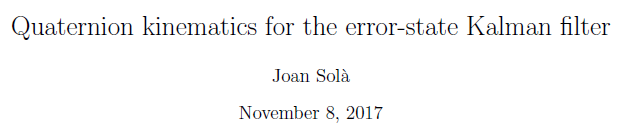

## Physical Law for gyroscope

$ \omega(t) = 2 \{ {{q(t)}^{*} \otimes \frac{\partial{q(t)}}{\partial{t}}} \}_{v} $

## Implementation of gyroscope law

In [47]:
def gyroscope_model(pose, t):
    
    dq_dt = jax.jacrev(lambda t: pose(t)[1])
    q_dot = dq_dt(t)
    
    _, q_t = pose(t)
    q_t_conjugate = quaternion_conjugate(q_t)
    
    q_omega = quaternion_product(q_t_conjugate, q_dot)
    _, vec_omega = quaternion_scalar_and_vector(q_omega)
    omega = 2 * vec_omega
    
    return omega

1. The quaternion is treated as a vector and a given time instant is a scalar
2. Thus the derivative of the quaternion object with respect to time will be given by a jacobian
3. The jacrev command in JAX uses reverse-mode automatic differentiation to compute the jacobian
4. We use the lambda function to provide the quaternion as a function of time via the syntax - "lambda t : q(t)"
5. The reverse-mode automatic differentiation was selected as it is a popular choice and does not affect the accuracy of the results
6. Following the automatic differentiation procedure, the custom quaternions functions were used to implement the governing equation for the underlying physical law of the gyroscope

## Physical Law for accelerometer

$a_{m}(t) = {q(t)}^{*} \otimes (a_{t}(t) - g) \otimes q(t)$

## Implementation of accelerometer law

In [48]:
def accelerometer_model(pose, t):
    
    r_t, q_t = pose(t)
    q_t_conjugate = quaternion_conjugate(q_t)
    
    d2r_dt2 = jax.jacrev(jax.jacrev(lambda t: pose(t)[0]))
    gravity_acc = jnp.array([0, 0, -9.81])
    
    vec_acc_true = d2r_dt2(t).squeeze() - gravity_acc
    q_acc_true = jnp.concatenate([jnp.array([0]), vec_acc_true], axis=-1)
    
    q_acc = quaternion_product(q_t_conjugate, quaternion_product(q_acc_true, q_t))
    _, acc = quaternion_scalar_and_vector(q_acc)
    
    return acc

1. Similar to the gyroscope computations, jacrev is used for obtaining the acceleration - but this time it is used twice in succession on the position vector
2. Gravity is subtracted from the true acceleration
3. The resultant acceleration vector is then converted to a quaternion via concatenation with a zero scalar part
4. The accelerometer equation is then implemented

## Reference for IMU sensor physical law equations

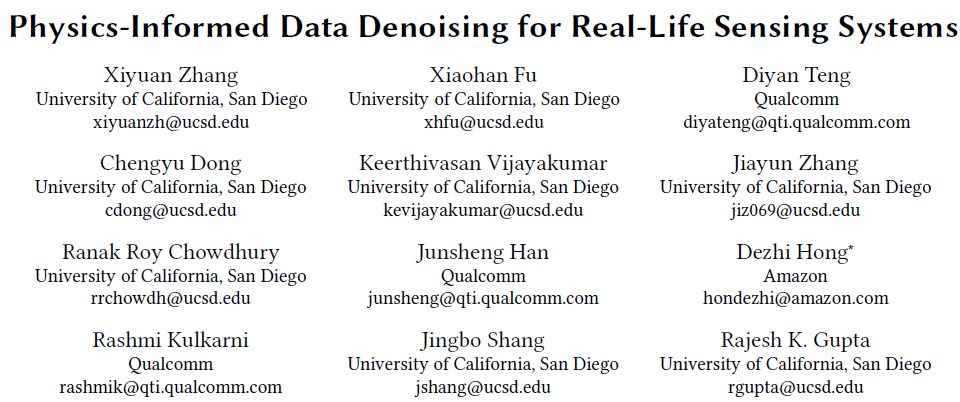

## Initialize pinn model

In [49]:
key = jax.random.PRNGKey(0)
pinn = PositionQuaternionNN(key)

## Vectorize all models using vmap

In [50]:
vmap_pose = jax.vmap(pinn)
vmap_gyroscope_model = jax.vmap(gyroscope_model, in_axes=(None, 0))
vmap_accelerometer_model = jax.vmap(accelerometer_model, in_axes=(None, 0))

1. Recall that all models were designed for a scalar input corresponding to a single instance of time
2. To apply these models on a temporal array consisting of multiple discrete time instants vectorization of these model is required
3. vmap is used for vectorization
4. In case of the sensor models there are two inputs and vectorization is required only along the first axis of the second input - therefore, we set "in_axes = (None, 0)"

## Compute initial pinn prediction

In [51]:
ini_r_t_array, ini_q_t_array = vmap_pose(t_array)
print(f"Initial Positions: {ini_r_t_array}, Initial Quaternions: {ini_q_t_array}")

Initial Positions: [[ 0.26760012 -0.20623934  0.34136438]
 [ 0.26760015 -0.20623931  0.34136444]
 [ 0.2676001  -0.20623937  0.3413644 ]
 ...
 [ 0.26759866 -0.2062389   0.34136215]
 [ 0.26759866 -0.2062389   0.34136215]
 [ 0.2675987  -0.20623893  0.34136215]], Initial Quaternions: [[ 0.990336   -0.05971143 -0.06610948 -0.1062955 ]
 [ 0.990336   -0.05971142 -0.06610947 -0.10629551]
 [ 0.990336   -0.05971142 -0.06610946 -0.10629551]
 ...
 [ 0.9903358  -0.05971173 -0.06611031 -0.10629623]
 [ 0.9903358  -0.05971174 -0.06611031 -0.10629623]
 [ 0.9903358  -0.05971172 -0.06611032 -0.10629622]]


## Compute initial gyroscope readings

In [52]:
ini_omega_t_array = vmap_gyroscope_model(pinn, t_array)
print(f"Initial Gyroscope readings: {ini_omega_t_array}")

Initial Gyroscope readings: [[-1.6364648e-07 -5.5468195e-07 -4.5002122e-07]
 [-1.6373808e-07 -5.5489255e-07 -4.5035569e-07]
 [-1.6383360e-07 -5.5510429e-07 -4.5069331e-07]
 ...
 [-2.4879014e-07 -7.0858823e-07 -7.0296983e-07]
 [-2.4886509e-07 -7.0869612e-07 -7.0315326e-07]
 [-2.4893984e-07 -7.0880657e-07 -7.0333641e-07]]


## Compute initial accelerometer readings

In [53]:
ini_acc_t_array = vmap_accelerometer_model(pinn, t_array)
print(f"Initial Accelerometer readings: {ini_acc_t_array}")

Initial Accelerometer readings: [[ 1.4090624 -1.0223441  9.654299 ]
 [ 1.4090623 -1.0223439  9.654299 ]
 [ 1.4090621 -1.0223439  9.654299 ]
 ...
 [ 1.4090797 -1.022347   9.654294 ]
 [ 1.4090798 -1.0223471  9.654294 ]
 [ 1.40908   -1.0223467  9.654294 ]]


## Equations defining the loss function for the pinn

$ L_{\text{acc}} = L_{\text{acc}} (t, \theta) = \sum_{j=1}^{3} \frac{1}{2} \left( \tilde{a}(t) - a(t) \right)_j^2 $

$ L_{\text{gyro}} = L_{\text{gyro}} (t, \theta_s, \theta_q) = \sum_{j=1}^{3} \frac{1}{2} \left( \tilde{\omega}(t) - \omega(t) \right)_j^2 $

$ L_{\text{total}} (\theta) = w_{\text{acc}} \frac{1}{N} \sum_{t_0}^{t_f} L_{\text{acc}}(t) + w_{\text{gyro}} \frac{1}{N} \sum_{t_0}^{t_f} L_{\text{gyro}}(t) + w_{\text{bc}} L_{\text{bc}} $

## Note on boundary loss

1. The boundary loss equation has not been mentioned above
2. The boundary loss is evaluated using two quaternions for which the squared difference is not a good metric
3. Since the tips of the quaternions sit on the surface of a four-dimensional sphere, the dot product between two quaternion provides a measure of similarity
4. Thus, the dot product subtracted from unity provides a notion for "quaternion loss" which we have implemented as boundary loss below

## Define loss function for the pinn

In [54]:
def loss_fn(network, data_gyro, data_acc):
    
    pred_gyro = jax.vmap(gyroscope_model, in_axes=(None, 0))(network, t_array)
    pred_acc = jax.vmap(accelerometer_model, in_axes=(None, 0))(network, t_array)
    
    weight_gyro = 0.8
    weight_acc = 1.0 - weight_gyro
    
    loss_gyro = jnp.mean(jnp.square(pred_gyro - data_gyro))
    loss_acc = jnp.mean(jnp.square(pred_acc - data_acc))
    
    loss_bc_add = True
    
    if loss_bc_add:
        
        loss_bc_left_dot = jnp.dot(q_bc_left, network(t_array[0])[1])
        loss_bc_right_dot = jnp.dot(q_bc_right, network(t_array[-1])[1])
        
        loss_bc_left = 1.0 - jnp.abs(loss_bc_left_dot)
        loss_bc_right = 1.0 - jnp.abs(loss_bc_right_dot)
        loss_bc = 0.5 * loss_bc_left + 0.5 * loss_bc_right
        
        loss_total = 0.3 * loss_bc + 0.6 * loss_gyro + 0.1 * loss_acc
        
    else:
        
        loss_total = weight_gyro * loss_gyro + weight_acc * loss_acc
    
    return loss_total

## Compute initial loss

In [55]:
ini_loss_val = loss_fn(pinn, data_gyro, data_acc)
print(f"Initial Loss value: {ini_loss_val}")

Initial Loss value: 12.141973495483398


## Hyperparameters

In [56]:
initial_learning_rate = 1e-3
decay_rate = 0.9
decay_steps = 500  # Define the number of steps after which the learning rate decays
n_epochs = 5000

## Define the learning rate scheduler

In [57]:
schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

## Notes on Optimization

1. The Hyperparameters of a network are "high-level" or "meta" parameters that guide the optimization and are not tampered with during the network learning in contrast with the weight parameters of the network
2. The Hyperparameters and Learning rate scheduler were purely empirical choices made based on trial and error with the objective of quickly demonstrating feasibility via a "proof-of-concept" algorithm!
3. We will use the "ADAM" optimizer owing to its widespread success in Deep Learning
4. Here is an operational statement about ADAM based on our PINN animation - recall that we had visualized the optimizer as a box with rotating wheels and likened it to the back of old computer boxes with the fans - in the same spirit, we can think of popular computer brands back from the 90's like Compaq and liken ADAM to the back of a Compaq computer - other optimizers might represent the back of other computer box brands like Hewlett Packard (HP) for instance
5. ADAM or any optimizer for that matter is trying to move to a local minimum on a loss function landscape and does this iteratively by navigating the loss landscape
6. At a given iteration - the optimizer will need to know how much the loss landscape is changing at that point in various directions so that it can then pick a direction to move in and once it picks a direction, it will need to decide how far it wants to move along that direction
7. The direction is estimated based on information about the loss function changes in various directions - in other words, information about the gradients of the loss functions with respect to its weight parameters is required
8. The distance to cover or step length is termed "learning rate" in the Deep Learning community
9. It is a good idea to have an adaptive learning rate rather than a fixed one and take smaller steps once we get close to the local minima (our desired target location) - for this reason - we have an adaptive learning rate which decays as the iterations proceed and that is why we employ a learning rate scheduler!
10. The exact details of the how the learning rate decays depends on the specific learning rate scheduler used - here we use an exponential decay for the learning rate scheduler and the specific were motivated purely based on trial and error
11. The optimization process benefits not only from having an adaptive learning rate but also from having an optimization algorithm that is capable of adapting by taking into account the history of the movement - this is what ADAM (Adaptive Moment estimation) stands for and does!

## Notes on Training Loop

1. We first setup up the ADAM optimizer with the learning rate scheduler
2. Next we extract the parameters (weights and biases) of the neural network using equinox's array filter and use these parameters to initialize the optimizer state
3. The optimizer state carries information required for the optimization algorithm like squares of the gradient and associated quantities
4. Then we define a function to carry out a single optimization step and wrap it in the jit compiler decorator for speed-up
5. The single optimization step function called "make_step" first extracts the current loss function value and its gradient with respect to the neural network parameters using equinox's filter and grad command. By default, this command filters for model parameters that are doubles and performs gradients with respect to them - this is an indirect way of extracting the weights and biases of the network. Note that the filter and grad does require all the inputs to the loss function for this command - model, data_gyro, data_acc
6. Then updates to the neural network model and the new optimizer state are computed
7. Finally the updates are applied to the neural network model parameters (weights and biases) and the quantities of interest are returned by the optimization step function
8. Next we initialize an empty list to record the loss history
9. The optimization is performed iteratively over the total number of epochs via the "make_step" function which performs a jit-compiled optimization step at every epoch

## Training Loop

In [58]:
optimizer = optax.adam(schedule)
opt_state = optimizer.init(eqx.filter(pinn, eqx.is_array))

@eqx.filter_jit
def make_step(network, optimizer_state):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(network, data_gyro, data_acc)
    network_updates, new_optimizer_state = optimizer.update(grad, optimizer_state, network)
    new_network = eqx.apply_updates(network, network_updates)
    return new_network, new_optimizer_state, loss

start_time = time.time()
loss_history = []
for epoch in range(n_epochs):
    pinn, opt_state, loss = make_step(pinn, opt_state)
    loss_history.append(loss)
    print(f"Epoch: {epoch}, loss: {loss}")
end_time = time.time()

print("Execution time: %s seconds" % (end_time - start_time))

Epoch: 0, loss: 12.141972541809082
Epoch: 1, loss: 11.808162689208984
Epoch: 2, loss: 11.839110374450684
Epoch: 3, loss: 11.7017183303833
Epoch: 4, loss: 11.363297462463379
Epoch: 5, loss: 10.766865730285645
Epoch: 6, loss: 9.827411651611328
Epoch: 7, loss: 8.511758804321289
Epoch: 8, loss: 6.867994785308838
Epoch: 9, loss: 5.057636260986328
Epoch: 10, loss: 3.368365526199341
Epoch: 11, loss: 2.149362325668335
Epoch: 12, loss: 1.6596680879592896
Epoch: 13, loss: 1.8788529634475708
Epoch: 14, loss: 2.4551608562469482
Epoch: 15, loss: 2.9801888465881348
Epoch: 16, loss: 3.2511723041534424
Epoch: 17, loss: 3.2472083568573
Epoch: 18, loss: 3.0293128490448
Epoch: 19, loss: 2.6855216026306152
Epoch: 20, loss: 2.307196855545044
Epoch: 21, loss: 1.9745391607284546
Epoch: 22, loss: 1.743937373161316
Epoch: 23, loss: 1.6386544704437256
Epoch: 24, loss: 1.6472529172897339
Epoch: 25, loss: 1.7321757078170776
Epoch: 26, loss: 1.8455679416656494
Epoch: 27, loss: 1.945132851600647
Epoch: 28, loss: 2.

## Compute final pinn prediction

In [59]:
vmap_pose_trained = jax.vmap(pinn)
_, final_q_t_array = vmap_pose_trained(t_array)
print(f"Final Quaternions prediction: {final_q_t_array}")

Final Quaternions prediction: [[ 0.76148665  0.17819309  0.48305538 -0.39375466]
 [ 0.76018375  0.17873377  0.4852526  -0.39332536]
 [ 0.7588754   0.17927659  0.48744985 -0.39288765]
 ...
 [ 0.48042992  0.40205395  0.7598402  -0.17373106]
 [ 0.48276427  0.40116546  0.7586967  -0.17431086]
 [ 0.48509544  0.40027303  0.7575472  -0.17488879]]


## Compute final gyroscope prediction

In [60]:
final_omega_t_array = vmap_gyroscope_model(pinn, t_array)
print(f"Final Gyroscope prediction: {final_omega_t_array}")

Final Gyroscope prediction: [[-0.34203547  2.0707033  -0.2551522 ]
 [-0.3434059   2.0749876  -0.25094122]
 [-0.34463906  2.0791605  -0.24671601]
 ...
 [-0.5803641  -2.167678   -0.07046168]
 [-0.5812018  -2.1681242  -0.07077117]
 [-0.5820369  -2.168535   -0.07106738]]


## Compute final accelerometer prediction

In [61]:
final_acc_t_array = vmap_accelerometer_model(pinn, t_array)
print(f"Final Accelerometer prediction: {final_acc_t_array}")

Final Accelerometer prediction: [[-8.857931  -1.0617373  5.0111637]
 [-8.869032  -1.0772624  4.9286356]
 [-8.879535  -1.0926121  4.845958 ]
 ...
 [-7.415366   1.1810105 -5.290989 ]
 [-7.4185743  1.1841108 -5.259983 ]
 [-7.4219704  1.1871856 -5.229003 ]]


## A quick look at the memory locations of functions used for final and initial prediction

In [62]:
id(vmap_pose), id(vmap_gyroscope_model), id(vmap_accelerometer_model)

(2370062360768, 2370062363008, 2370062356288)

In [63]:
id(vmap_pose_trained), id(vmap_gyroscope_model), id(vmap_accelerometer_model)

(2370237006208, 2370062363008, 2370062356288)

## Note on the memory locations

1. The "vmap_gyroscope_model" and "vmap_accelerometer_model" are functions that take as input the temporal array and the pinn model with the current weight parameters and are stored at the memory locations given above
2. Thus, when retrieved from memory - "vmap_gyroscope_model" and "vmap_accelerometer_model" will take as processing input - the temporal array and the current pinn weights
3. The "vmap_pose" is the vectorized form of the pinn model with its initial weights and it is stored in memory at the location given above
4. Now, when "vmap_pose" is retrieved from memory, it remembers the vectorized form of the "old pinn" which then acts on the temporal array - the weights are not automatically updated in memory and since it does not explicity take the trained weights as input - it is completely unaware of the pinn training!
5. The "vmap_pose_trained" is the vectorized form of the pinn model committed to memory after training and this is reflected via the new memory location above
6. Therefore, applying "vmap_pose_trained" on the temporal array results in a vectorized pinn model being retrieved from memory and then acting on the temporal array. However, this time - the vectorized function committed to memory had its weights trained!

## Compute final boundary loss

In [64]:
loss_bc_left_dot = jnp.dot(q_bc_left, final_q_t_array[0])
loss_bc_right_dot = jnp.dot(q_bc_right, final_q_t_array[-1])
loss_bc_left_val = 1.0 - jnp.abs(loss_bc_left_dot)
loss_bc_right_val = 1.0 - jnp.abs(loss_bc_right_dot)
loss_bc_val = 0.5 * loss_bc_left_val + 0.5 * loss_bc_right_val
print(f"Boundary loss value: {loss_bc_val}")

Boundary loss value: 4.7087669372558594e-05


## Function to extract inclination and heading angles from quaternions

In [65]:
def quat_to_rpy(quat):
    w, x, y, z = quat
    roll = jnp.arctan2(2.0 * (w * x - y * z), 1.0 - 2.0 * (x * x + y * y))
    pitch = jnp.arcsin(2.0 * (w * y - z * x))
    yaw = jnp.arctan2(2.0 * (w * z + x * y), 1.0 - 2.0 * (y * y + z * z))
    return jnp.array([roll, pitch, yaw])

## Vectorized conversion

In [66]:
rpy_angles_ref_rad = jax.vmap(quat_to_rpy)(data_quat)
rpy_angles_pinn_rad = jax.vmap(quat_to_rpy)(final_q_t_array)

Converting quaternions to inclination (roll and pitch) and heading angles are a great example of vectorizing a custom function via the vmap feature provided by JAX for massive speed-up!

## Radian to degrees

In [67]:
rpy_angles_ref = jnp.degrees(rpy_angles_ref_rad)
rpy_angles_pinn = jnp.degrees(rpy_angles_pinn_rad)

## Formula for quaternion to rotation matrix

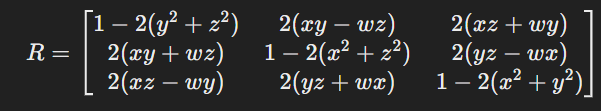

1. The Rodrigues rotation formula can be used to derive a rotation matrix for a given axis-angle representation
2. The axis-angle form can be easily represented as a quaternion
3. Thus the rotation matrix derived from Rodriguez rotation formula can be expressed in terms of the quaternion components
4. The first and second columns of the rotation matrix are the major and minor axes of the IMU respectively
5. These axes are unit vectors
6. The pitch is the counter-clokwise angle made by the major axis with respect to the horizontal (EN) plane of the ENU frame and given that the major axis is a unit vector - it is simply the negative of the inverse sine of the z (up) component of the first column
7. The yaw is the counter-clockwise rotation of the major axis about the z (up) axis and is simply given by the inverse tangent of the ratio of the y-component of the major axis to its x-component
8. The roll is the counter-clockwise rotation about the x (east) axis and is given by the negative of the inverse tangent of the ratio of the y-component of the final IMU axis to its z-component
9. It is worth noting that the Rodrigues rotation formulation can also be used to express axis-angle rotations in terms of quaternion products and this can then be applied to succesive time instants for deriving the quaternion angular velocity formula

## Plot loss history

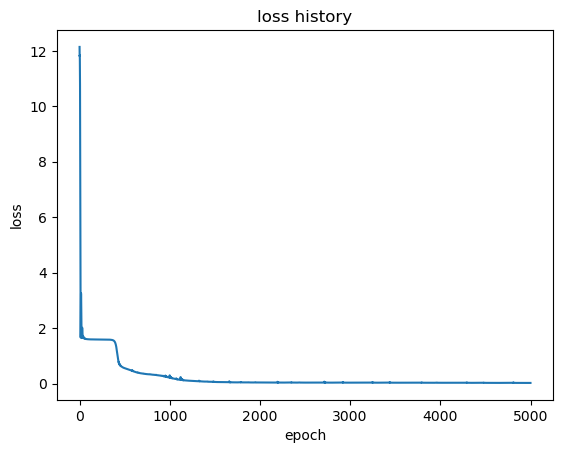

In [68]:
plt.figure()
plt.plot(loss_history)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("loss history")
plt.show()

## Plot loss history on a log scale

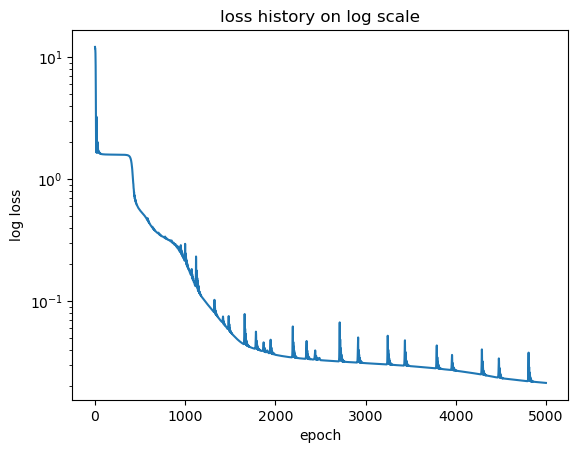

In [69]:
plt.figure()
plt.plot(loss_history)
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")
plt.title("loss history on log scale")
plt.show()

## Plot results for accelerometer

Text(0.5, 1.0, 'accelerometer results')

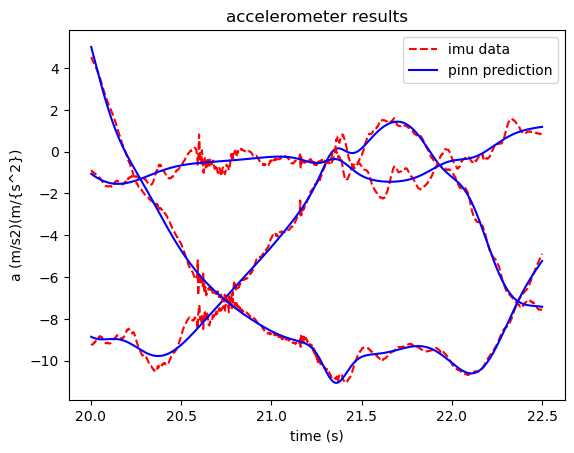

In [70]:
plt.figure()
for i in range(final_acc_t_array.shape[1]):
    if i == 0:
        plt.plot(t_array, data_acc[:, i], 'r--', label="imu data")
        plt.plot(t_array, final_acc_t_array[:, i], 'b', label="pinn prediction")
    else:
        plt.plot(t_array, data_acc[:, i], 'r--')
        plt.plot(t_array, final_acc_t_array[:, i], 'b')
plt.legend()
plt.xlabel("time (s)")
plt.ylabel(r'a (m/s2)(m/{s^2})')
plt.title("accelerometer results")

## Plot results for gyroscope

Text(0.5, 1.0, 'gyroscope results')

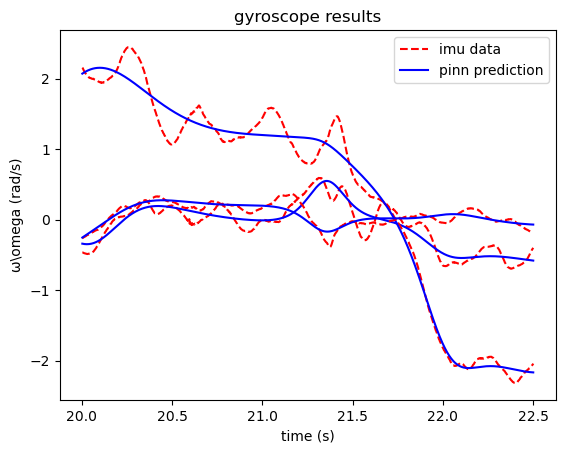

In [71]:
plt.figure()
for i in range(final_omega_t_array.shape[1]):
    if i == 0:
        plt.plot(t_array, data_gyro[:, i], 'r--', label="imu data")
        plt.plot(t_array, final_omega_t_array[:, i], 'b', label="pinn prediction")
    else:
        plt.plot(t_array, data_gyro[:, i], 'r--')
        plt.plot(t_array, final_omega_t_array[:, i], 'b')
plt.legend()
plt.xlabel("time (s)")
plt.ylabel(r'ω\omega (rad/s)')
plt.title("gyroscope results")

## Plot results for orientation in terms of quaternions

Text(0.5, 1.0, 'orientation results (quaternions)')

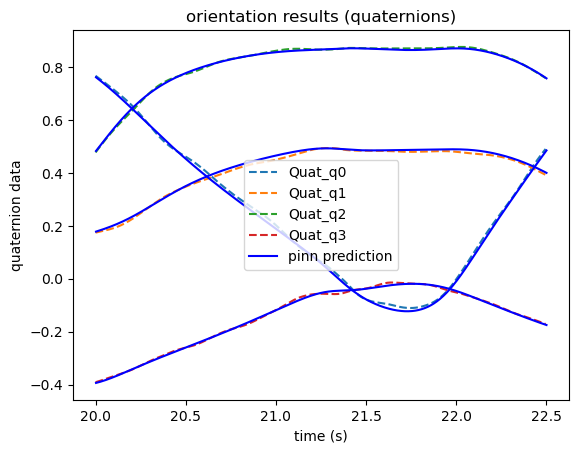

In [72]:
quat_column_names = list(df_ref.columns[1:])
plt.figure()
[plt.plot(t_ref_array, data_quat[:, i], '--', label=quat_column_names[i]) for i in range(data_quat.shape[1])]
for i in range(final_q_t_array.shape[1]):
    if i == 0:
        plt.plot(t_array, final_q_t_array[:, i], 'b', label="pinn prediction")
    else:
        plt.plot(t_array, final_q_t_array[:, i], 'b')
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("quaternion data")
plt.title("orientation results (quaternions)")

## Plot results for roll

Text(0.5, 1.0, 'roll results')

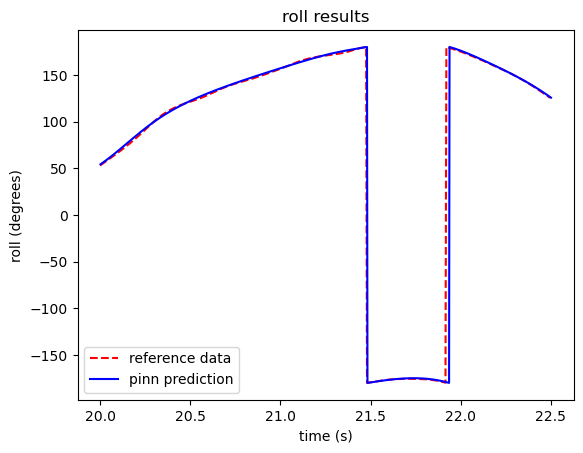

In [73]:
plt.figure()
plt.plot(t_ref_array, rpy_angles_ref[:,0], 'r--', label="reference data")
plt.plot(t_array, rpy_angles_pinn[:,0], 'b', label="pinn prediction")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("roll (degrees)")
plt.title("roll results")

## Plot results for pitch

Text(0.5, 1.0, 'pitch results')

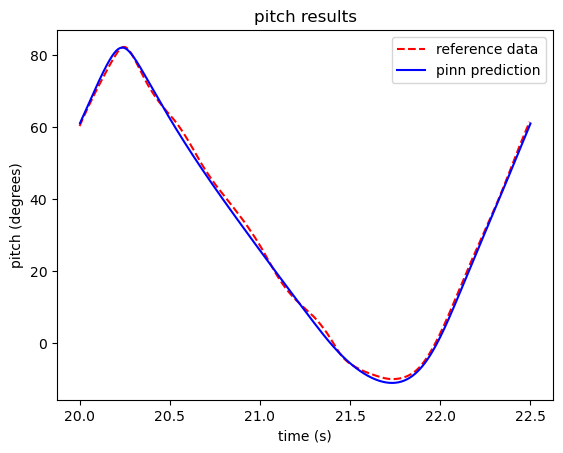

In [74]:
plt.figure()
plt.plot(t_ref_array, rpy_angles_ref[:,1], 'r--', label="reference data")
plt.plot(t_array, rpy_angles_pinn[:,1], 'b', label="pinn prediction")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("pitch (degrees)")
plt.title("pitch results")

## Plot results for yaw

Text(0.5, 1.0, 'yaw results')

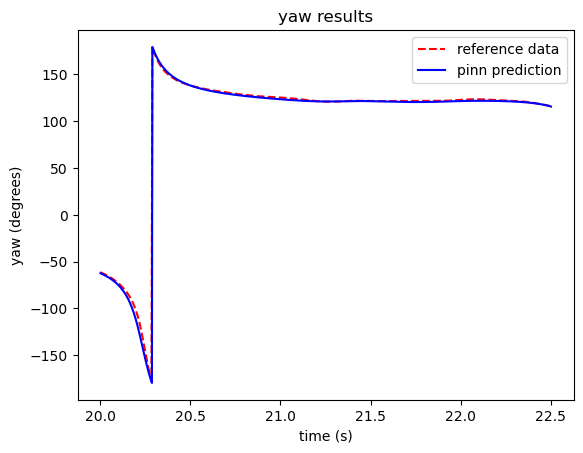

In [75]:
plt.figure()
plt.plot(t_ref_array, rpy_angles_ref[:,2], 'r--', label="reference data")
plt.plot(t_array, rpy_angles_pinn[:,2], 'b', label="pinn prediction")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("yaw (degrees)")
plt.title("yaw results")